# Testing surface attribute calculation
## Introduction
There are different methods available to calculate both gradient (slope steepness and slope direction) and curvature attributes of a given surface.

The EIS-toolkit contains following defaults, however, they're interchangeable to some point. Results of each calculation returns a dictionary containing the names (key) and respective arrays and metadata (tuple).


## Examples

### Set-up

In [1]:
# Modules and basic set-up
import numpy as np
import os
import rasterio

import sys
sys.path.append('..')

from eis_toolkit.surface_attributes.parameters import first_order, second_order_basic_set
from eis_toolkit.surface_attributes.utilities import classify_aspect, nodata_to_nan
from eis_toolkit.utilities.conversions import convert_deg_to_rad, convert_rad_to_deg, convert_deg_to_rise

np.set_printoptions(suppress=True)

# Path to data
file_paths = ['../tests/data/local/data/dgm10_fg.tif',
              '../tests/data/local/data/dgm25cm.tif',
              '../tests/data/remote/small_raster.tif',
              '../tests/data/local/data/GeophysicsMagRTP_USCanada.tif',
              '../tests/data/local/data/GeophysicsMagRTP_USCanada_3857.tif',]

file_path = file_paths[2]

file_name = os.path.splitext(os.path.basename(file_path))[0]   
results_path = '../tests/data/local/results/surface_derivatives/'
results_basename = os.path.basename(file_path).split('.')[0]
results_ext = ".tif"

raster = rasterio.open(file_path)
nodata_replacement = -9999


In [2]:
raster = rasterio.open(file_path)


In [3]:
slope_tolerance = 10
method = "Evans"
parameter = "K"

slope = first_order(raster, parameters=["G"], method="Evans", slope_gradient_unit="degrees")
slope_array = slope["G"][0]
slope_masked = np.ma.masked_less_equal(slope_array, slope_tolerance).mask
slope_zero_masked = np.ma.masked_values(slope_array, 0, shrink=False).mask

slope_st = first_order(raster, parameters=["G"], method=method, slope_gradient_unit="degrees", slope_tolerance=slope_tolerance)
slope_st_array = slope_st["G"][0]
slope_st_array_mask = np.ma.masked_less_equal(slope_st_array, slope_tolerance).mask

deriv = second_order_basic_set(raster, parameters=[parameter], method=method)
deriv_array = deriv[parameter][0]

deriv_st = second_order_basic_set(raster, parameters=[parameter], method=method, slope_tolerance=slope_tolerance)
deriv_st_array = deriv_st[parameter][0]

### Helper

In [4]:
import math
import matplotlib.pyplot as plt

# Plotting
def plots_side_by_side(box_width, box_heigth, *argv):
    """Plot multiple images side by side"""
    num_cols = 5
    
    if isinstance(argv[0], str):
      num_images = 1
    elif isinstance(argv[0], tuple):
      num_images = len(argv)
            
    num_rows = math.ceil(num_images/num_cols)
    
    plt.figure(figsize=(box_width*num_cols, box_heigth*num_rows))

    for i in range(0, num_images):
      parameter = argv[i][0] if num_images > 1 else argv[0]
      image = argv[i][1] if num_images > 1 else argv[1]

      plt.subplot(num_rows, num_cols, i+1)
      plt.subplots_adjust(wspace=0.1, hspace=0)
      plt.title(parameter)
      plt.axis("off")
      plt.imshow(image, cmap='viridis')
      plt.colorbar(location='right', shrink=0.5, pad=0.02);
      
      i += 1
      
      
# Exporting
def export_raster(array, name, meta=None, export=True, path=results_path):
    if export is True:  
      file_path = path + name + '.tif'
      
      if meta is not None:
          with rasterio.open(file_path, 'w', **meta) as dst:
              dst.write(np.float32(array), 1)
      else:
          with rasterio.open(file_path, 'w', driver='GTiff', 
                          height=array.shape[0], width=array.shape[1], 
                          count=1, dtype=np.float32) as dst:
              dst.write(array, 1)

### First order derivatives

#### Horn (1981)
Slope and Aspect in degrees.

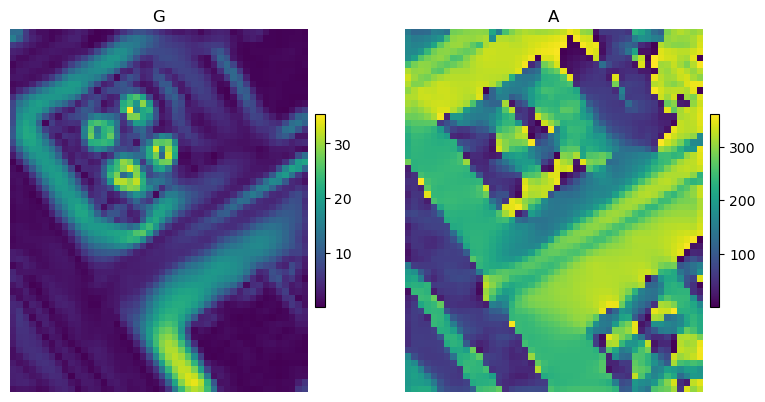

In [5]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_gradient_unit="degrees", slope_direction_unit="degrees")

slope = gradient["G"][0]
#slope = nodata_to_nan(slope, nodata_replacement)

aspect = gradient["A"][0]
#aspect = nodata_to_nan(aspect, nodata_replacement)

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"horn_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"horn_{results_basename}_A", gradient["A"][1], export=export)

In [6]:
aspect.shape

(56, 46)

In [7]:
np.nanmean(nodata_to_nan(slope, nodata_replacement))

7.0736985

#### Zevenbergen & Thorne (1987)
Slope and Aspect in degrees.

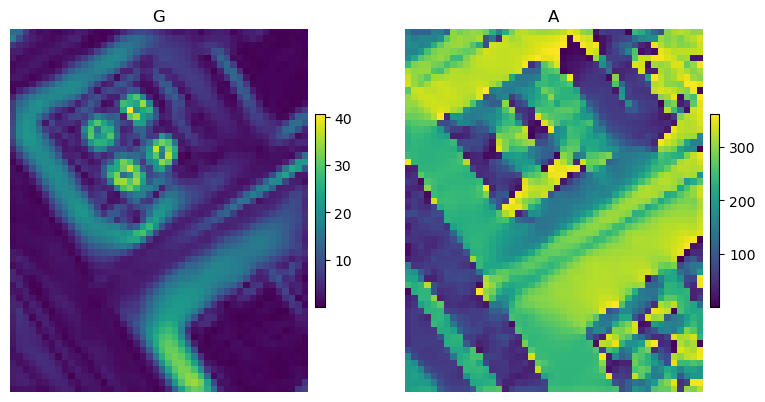

In [8]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_gradient_unit="degrees", slope_direction_unit="degrees", method="Zevenbergen")

slope = gradient["G"][0]
aspect = gradient["A"][0]

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"zt_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"zt_{results_basename}_A", gradient["A"][1], export=export)

#### Evans-Young (1978/1979)
Slope and Aspect in degrees.

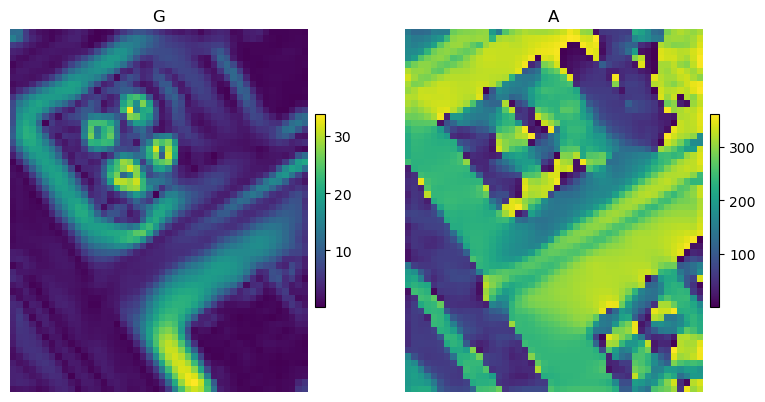

In [16]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_gradient_unit="degrees", slope_direction_unit="degrees", method="Young")

slope = gradient["G"][0]
aspect = gradient["A"][0]

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"young_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"young_{results_basename}_A", gradient["A"][1], export=export)

#### Evans (1979)
Slope and Aspect in degrees with **slope_tolerance = 10** degrees.

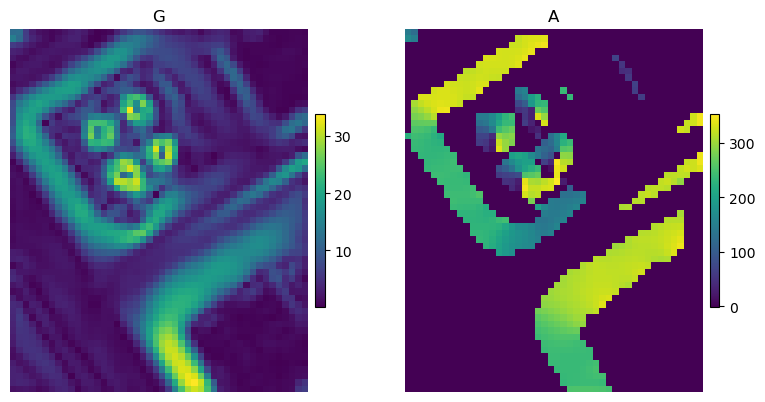

In [9]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_tolerance=10, slope_gradient_unit="degrees", slope_direction_unit="degrees", method="Evans")

slope = gradient["G"][0]
aspect = gradient["A"][0]

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"evans_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"evans_{results_basename}_A", gradient["A"][1], export=export)

### Second order basic curvatures
#### Zevenbergen & Thorne (1987)

In [10]:
second_order = second_order_basic_set(raster, parameters=["planc", "profc", "profc_min", "profc_max", "longc", "crosc", "rot", "K", "genc", "tangc"], method="Zevenbergen")

clip_percentile = 5

planc = second_order["planc"][0]
planc_clip = np.clip(planc, np.percentile(planc, clip_percentile), np.percentile(planc, 100-clip_percentile))

profc = second_order["profc"][0]
profc_min = second_order["profc_min"][0]
profc_max = second_order["profc_max"][0]
longc = second_order["longc"][0]
crosc = second_order["crosc"][0]
rot = second_order["rot"][0]
K =  second_order["K"][0]
genc = second_order["genc"][0]
tangc = second_order["tangc"][0]



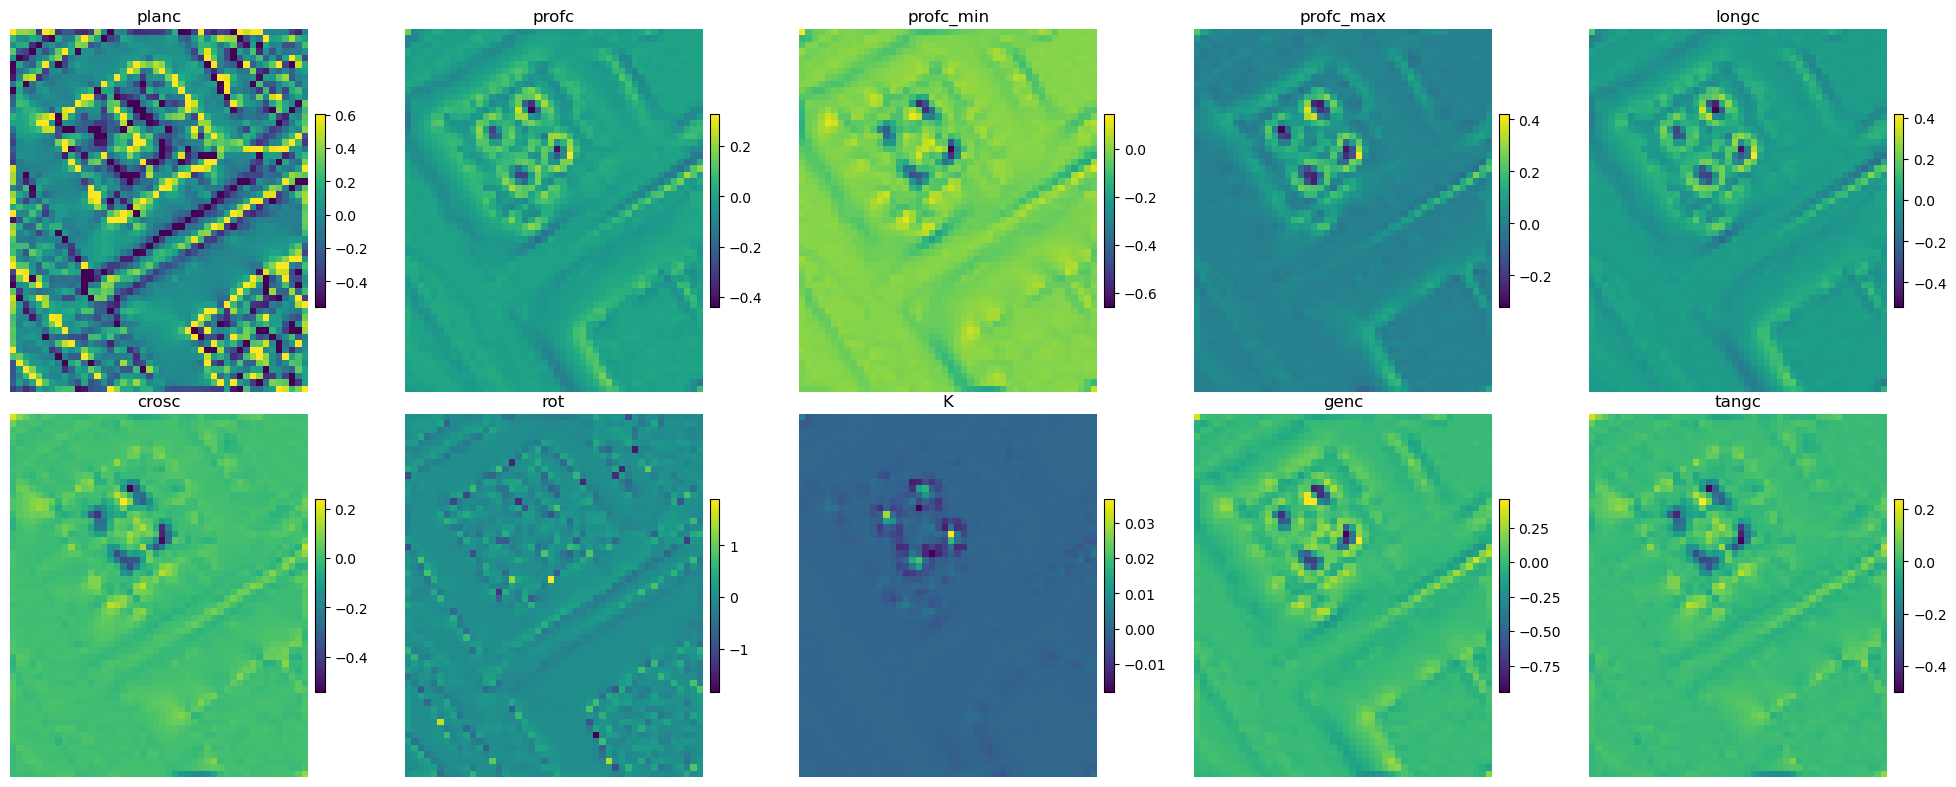

In [11]:
# Plotting
plots_side_by_side(5, 5, 
                   ("planc", nodata_to_nan(planc_clip, nodata_replacement)), 
                   ("profc", nodata_to_nan(profc, nodata_replacement)), 
                   ("profc_min", nodata_to_nan(profc_min, nodata_replacement)), 
                   ("profc_max", nodata_to_nan(profc_max, nodata_replacement)), 
                   ("longc", nodata_to_nan(longc, nodata_replacement)), 
                   ("crosc", nodata_to_nan(crosc, nodata_replacement)), 
                   ("rot", nodata_to_nan(rot, nodata_replacement)), 
                   ("K", nodata_to_nan(K, nodata_replacement)), 
                   ("genc", nodata_to_nan(genc, nodata_replacement)), 
                   ("tangc", nodata_to_nan(tangc, nodata_replacement)))


In [20]:
# Export 
export = False
export_raster(planc, f"zt_{results_basename}_planc", second_order["planc"][1], export=export)
export_raster(profc, f"zt_{results_basename}_profc", second_order["profc"][1], export=export)
export_raster(profc_min, f"zt_{results_basename}_profc_min", second_order["profc_min"][1], export=export)
export_raster(profc_max, f"zt_{results_basename}_profc_max", second_order["profc_max"][1], export=export)
export_raster(longc, f"zt_{results_basename}_longc", second_order["longc"][1], export=export)
export_raster(crosc, f"zt_{results_basename}_crosc", second_order["crosc"][1], export=export)
export_raster(rot, f"zt_{results_basename}_rot", second_order["rot"][1], export=export)
export_raster(K, f"zt_{results_basename}_K", second_order["K"][1], export=export)
export_raster(genc, f"zt_{results_basename}_genc", second_order["genc"][1], export=export)
export_raster(tangc, f"zt_{results_basename}_tangc", second_order["tangc"][1], export=export)


#### Evans-Young (1978/1979)

In [12]:
second_order = second_order_basic_set(raster, parameters=["planc", "profc", "profc_min", "profc_max", "longc", "crosc", "rot", "K", "genc", "tangc"], method="Young")

planc = second_order["planc"][0]
profc = second_order["profc"][0]
profc_min = second_order["profc_min"][0]
profc_max = second_order["profc_max"][0]
longc = second_order["longc"][0]
crosc = second_order["crosc"][0]
rot = second_order["rot"][0]
K =  second_order["K"][0]
genc = second_order["genc"][0]
tangc = second_order["tangc"][0]



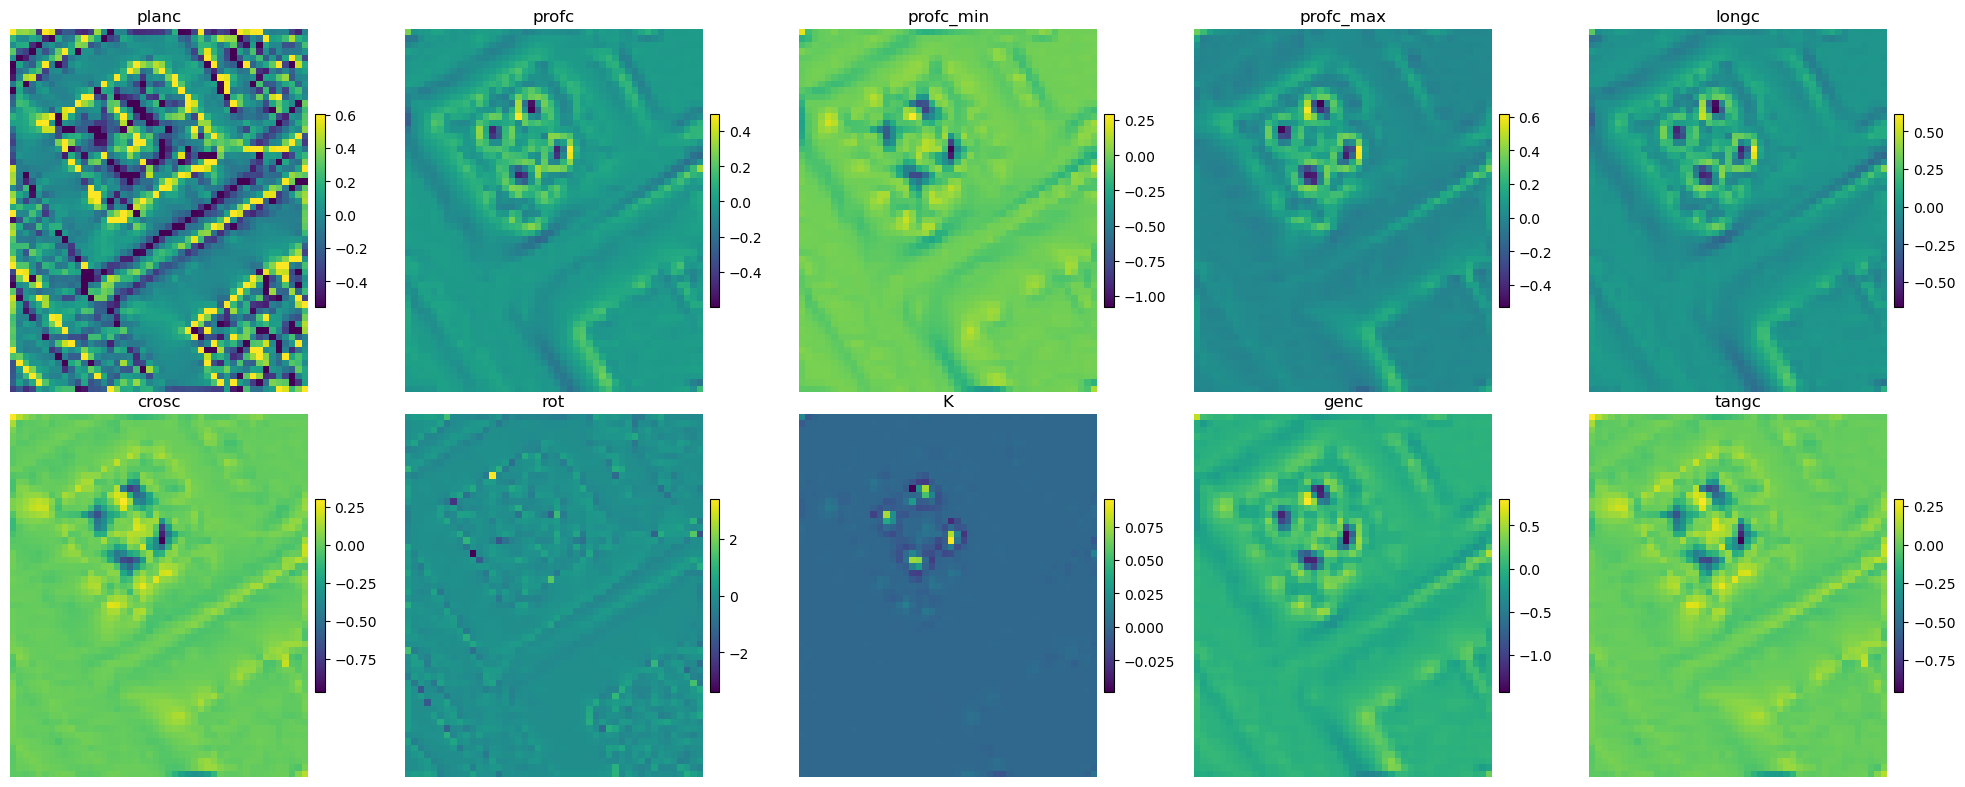

In [13]:
# Plotting
plots_side_by_side(5, 5, 
                   ("planc", nodata_to_nan(planc_clip, nodata_replacement)), 
                   ("profc", nodata_to_nan(profc, nodata_replacement)), 
                   ("profc_min", nodata_to_nan(profc_min, nodata_replacement)), 
                   ("profc_max", nodata_to_nan(profc_max, nodata_replacement)), 
                   ("longc", nodata_to_nan(longc, nodata_replacement)), 
                   ("crosc", nodata_to_nan(crosc, nodata_replacement)), 
                   ("rot", nodata_to_nan(rot, nodata_replacement)), 
                   ("K", nodata_to_nan(K, nodata_replacement)), 
                   ("genc", nodata_to_nan(genc, nodata_replacement)), 
                   ("tangc", nodata_to_nan(tangc, nodata_replacement)))

In [23]:
# Export 
export = False
export_raster(planc, f"young_{results_basename}_planc", second_order["planc"][1], export=export)
export_raster(profc, f"young_{results_basename}_profc", second_order["profc"][1], export=export)
export_raster(profc_min, f"young_{results_basename}_profc_min", second_order["profc_min"][1], export=export)
export_raster(profc_max, f"young_{results_basename}_profc_max", second_order["profc_max"][1], export=export)
export_raster(longc, f"young_{results_basename}_longc", second_order["longc"][1], export=export)
export_raster(crosc, f"young_{results_basename}_crosc", second_order["crosc"][1], export=export)
export_raster(rot, f"young_{results_basename}_rot", second_order["rot"][1], export=export)
export_raster(K, f"young_{results_basename}_K", second_order["K"][1], export=export)
export_raster(genc, f"young_{results_basename}_genc", second_order["genc"][1], export=export)
export_raster(tangc, f"young_{results_basename}_tangc", second_order["tangc"][1], export=export)
